In [1]:
from typing import Any, List, Optional
from dataclasses import dataclass
import itertools
from numpy.typing import ArrayLike
import numpy as np
import symengine
from pycalphad import Model
from espei.paramselect import _build_feature_matrix
from espei.parameter_selection.model_building import make_successive, build_redlich_kister_candidate_models
from espei.paramselect import *
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v


Dataset = Dict[str, Any]  # Typing stub

from espei.parameter_selection.utils import build_sitefractions, feature_transforms, shift_reference_state
class FittingStep():
    parameter_name: str
    data_types_read: List[str]
    features: List[symengine.Expr]
    supported_reference_states: List[str]

    @staticmethod
    def transform_data(d: ArrayLike, model: Optional[Model] = None) -> ArrayLike:  # data may be muddied with symbols from Model
        return d

    @staticmethod
    def transform_feature(f: symengine.Expr, model: Optional[Model] = None) -> symengine.Expr:
        return f

    @classmethod
    def get_feature_sets(cls):
        return make_successive(cls.features)

    # modification of espei.parameter_selection.utils.get_data_quantities
    # this modified version changes how we access the property of the fixed model to subtract out that contribution
    # TODO: rename, maybe get_regression_rhs (and build_feature_matrix => get_regression_matrix)
    # TODO: default implementation? maybe raises, maybe check Gibbs subclass
    @classmethod
    def get_data_quantities(cls, desired_property, fixed_model, fixed_portions, data, sample_condition_dicts):
        """
        Parameters
        ----------
        desired_property : str
            String property corresponding to the features that could be fit, e.g. HM, SM_FORM, CPM_MIX
        fixed_model : pycalphad.Model
            Model with all lower order (in composition) terms already fit. Pure
            element reference state (GHSER functions) should be set to zero.
        fixed_portions : List[symengine.Basic]
            SymEngine expressions for model parameters and interaction productions for
            higher order (in T) terms for this property, e.g. [0, 3.0*YS*v.T]. In
            [qty]/mole-formula.
        data : List[Dict[str, Any]]
            ESPEI single phase datasets for this property.

        Returns
        -------
        np.ndarray[:]
            Ravelled data quantities in [qty]/mole-formula

        Notes
        -----
        pycalphad Model parameters (and therefore fixed_portions) are stored as per
        mole-formula quantites, but the calculated properties and our data are all
        in [qty]/mole-atoms. We multiply by mole-atoms/mole-formula to convert the
        units to [qty]/mole-formula.

        """
        mole_atoms_per_mole_formula_unit = fixed_model._site_ratio_normalization
        # Define site fraction symbols that will be reused
        YS = Symbol('YS')
        Z = Symbol('Z')
        V_I, V_J, V_K = Symbol('V_I'), Symbol('V_J'), Symbol('V_K')
        phase_name = fixed_model.phase_name

        # Construct flattened list of site fractions corresponding to the ravelled data (from shift_reference_state)
        site_fractions = []
        for ds in data:
            for _ in ds['conditions']['T']:
                sf = build_sitefractions(phase_name, ds['solver']['sublattice_configurations'], ds['solver'].get('sublattice_occupancies', np.ones((len(ds['solver']['sublattice_configurations']), len(ds['solver']['sublattice_configurations'][0])), dtype=np.float_)))
                site_fractions.append(sf)
        site_fractions = list(itertools.chain(*site_fractions))

        if desired_property in feature_transforms:
            feat_transform = feature_transforms[desired_property]
        elif desired_property.startswith("V0"):
            feat_transform = lambda x: x  # TODO: hack because V0 should be V0 subtracted out
        else:
            feat_transform = lambda x: 0  # TODO: hack because VA shouldn't subtract out V0 contributions from model
        # print("data_qtys 1", data)
        data_qtys = np.concatenate(shift_reference_state(data, feat_transform, fixed_model, mole_atoms_per_mole_formula_unit), axis=-1)
        # print("data_qtys 2", data_qtys)
        # Remove existing partial model contributions from the data, convert to per mole-formula units
        # TODO: assumption of Gibbs energy fitting here - assumes that we're always fitting against the existing ast/GM.
        data_qtys = data_qtys - feat_transform(getattr(fixed_model, desired_property))*mole_atoms_per_mole_formula_unit
        # print("data_qtys 3", data_qtys)
        # Subtract out high-order (in T) parameters we've already fit, already in per mole-formula units
        data_qtys = data_qtys - feat_transform(sum(fixed_portions))
        # print("data_qtys 4", data_qtys)
        # if any site fractions show up in our data_qtys that aren't in this datasets site fractions, set them to zero.
        for sf, i, cond_dict in zip(site_fractions, data_qtys, sample_condition_dicts):
            missing_variables = symengine.S(i).atoms(v.SiteFraction) - set(sf.keys())
            # print("missing vars", missing_variables)
            sf.update({x: 0. for x in missing_variables})
            # The equations we have just have the site fractions as YS
            # and interaction products as Z, so take the product of all
            # the site fractions that we see in our data qtys
            sf.update(cond_dict)
        # print("data_qtys 5", data_qtys)
        data_qtys = [symengine.S(i).xreplace(sf).evalf() for i, sf in zip(data_qtys, site_fractions)]
        # print("data_qtys 6", data_qtys)
        data_qtys = np.asarray(data_qtys, dtype=np.float_)
        # print("data_qtys 7", data_qtys)

        # Not in the orig function, added later. Might need to change for more advanced data model
        data_quantities = cls.transform_data(data_qtys, fixed_model)
        # one last sweep through subs sample_condition_dicts because our transform from the fixed model may have re-introduced symbols
        # print("data_quantities", data_quantities)
        # unforunately we need to handle the case that data quanities didn't get made into a symbolic form
        data_quantities = np.asarray([(dq.subs(scd) if not isinstance(dq, float) else dq) for dq, scd in zip(data_quantities, sample_condition_dicts)], dtype=np.object_)
        # print("data_quantities x", data_quantities)
        return data_quantities

class ModelFittingDescription():
    def __init__(self, *fitting_steps) -> None:
        self.fitting_steps = fitting_steps


class StepV0(FittingStep):
    parameter_name = "V0"
    data_types_read = ["V0"]
    features = [symengine.S.One]
    supported_reference_states = [""]  # TODO: add mixing support

    # TODO: modify to only V0 parts
    @classmethod
    def get_data_quantities(cls, desired_property, fixed_model, fixed_portions, data, sample_condition_dicts):
        """
        Parameters
        ----------
        desired_property : str
            String property corresponding to the features that could be fit, e.g. HM, SM_FORM, CPM_MIX
        fixed_model : pycalphad.Model
            Model with all lower order (in composition) terms already fit. Pure
            element reference state (GHSER functions) should be set to zero.
        fixed_portions : List[symengine.Basic]
            SymEngine expressions for model parameters and interaction productions for
            higher order (in T) terms for this property, e.g. [0, 3.0*YS*v.T]. In
            [qty]/mole-formula.
        data : List[Dict[str, Any]]
            ESPEI single phase datasets for this property.

        Returns
        -------
        np.ndarray[:]
            Ravelled data quantities in [qty]/mole-formula

        Notes
        -----
        pycalphad Model parameters (and therefore fixed_portions) are stored as per
        mole-formula quantites, but the calculated properties and our data are all
        in [qty]/mole-atoms. We multiply by mole-atoms/mole-formula to convert the
        units to [qty]/mole-formula.

        """
        mole_atoms_per_mole_formula_unit = fixed_model._site_ratio_normalization
        # Define site fraction symbols that will be reused
        YS = Symbol('YS')
        Z = Symbol('Z')
        V_I, V_J, V_K = Symbol('V_I'), Symbol('V_J'), Symbol('V_K')
        phase_name = fixed_model.phase_name

        # Construct flattened list of site fractions corresponding to the ravelled data (from shift_reference_state)
        site_fractions = []
        for ds in data:
            for _ in ds['conditions']['T']:
                sf = build_sitefractions(phase_name, ds['solver']['sublattice_configurations'], ds['solver'].get('sublattice_occupancies', np.ones((len(ds['solver']['sublattice_configurations']), len(ds['solver']['sublattice_configurations'][0])), dtype=np.float_)))
                site_fractions.append(sf)
        site_fractions = list(itertools.chain(*site_fractions))

        if desired_property in feature_transforms:
            feat_transform = feature_transforms[desired_property]
        elif desired_property.startswith("V0"):
            feat_transform = lambda x: x  # TODO: hack because V0 should be V0 subtracted out
        else:
            feat_transform = lambda x: 0  # TODO: hack because VA shouldn't subtract out V0 contributions from model
        # print("data_qtys 1", data)
        data_qtys = np.concatenate(shift_reference_state(data, feat_transform, fixed_model, mole_atoms_per_mole_formula_unit), axis=-1)
        # print("data_qtys 2", data_qtys)
        # Remove existing partial model contributions from the data, convert to per mole-formula units
        # TODO: assumption of Gibbs energy fitting here - assumes that we're always fitting against the existing ast/GM.
        data_qtys = data_qtys - feat_transform(getattr(fixed_model, desired_property))*mole_atoms_per_mole_formula_unit
        # print("data_qtys 3", data_qtys)
        # Subtract out high-order (in T) parameters we've already fit, already in per mole-formula units
        data_qtys = data_qtys - feat_transform(sum(fixed_portions))
        # print("data_qtys 4", data_qtys)
        # if any site fractions show up in our data_qtys that aren't in this datasets site fractions, set them to zero.
        for sf, i, cond_dict in zip(site_fractions, data_qtys, sample_condition_dicts):
            missing_variables = symengine.S(i).atoms(v.SiteFraction) - set(sf.keys())
            # print("missing vars", missing_variables)
            sf.update({x: 0. for x in missing_variables})
            # The equations we have just have the site fractions as YS
            # and interaction products as Z, so take the product of all
            # the site fractions that we see in our data qtys
            sf.update(cond_dict)
        # print("data_qtys 5", data_qtys)
        data_qtys = [symengine.S(i).xreplace(sf).evalf() for i, sf in zip(data_qtys, site_fractions)]
        # print("data_qtys 6", data_qtys)
        data_qtys = np.asarray(data_qtys, dtype=np.float_)
        # print("data_qtys 7", data_qtys)

        # Not in the orig function, added later. Might need to change for more advanced data model
        data_quantities = cls.transform_data(data_qtys, fixed_model)
        # one last sweep through subs sample_condition_dicts because our transform from the fixed model may have re-introduced symbols
        # print("data_quantities", data_quantities)
        # unforunately we need to handle the case that data quanities didn't get made into a symbolic form
        data_quantities = np.asarray([(dq.subs(scd) if not isinstance(dq, float) else dq) for dq, scd in zip(data_quantities, sample_condition_dicts)], dtype=np.object_)
        # print("data_quantities x", data_quantities)
        return data_quantities


class StepLogVA(FittingStep):
    # V = V0*exp(VA), to linearize in terms of VA features, we want to fit
    # VA = ln(V/V0)
    parameter_name = "VA"
    data_types_read = ["VM"]
    features = [v.T, v.T**2, v.T**3, v.T**(-1)]
    supported_reference_states = [""]  # TODO: add mixing support

    @staticmethod
    def transform_data(d, model: Model) -> ArrayLike:
        # We are given samples of volume (V) as our data (d).
        # ln(V/V0) = VA
        # cast to object_ because the real type may become a symengine.Expr
        d = np.asarray(d, dtype=np.object_)
        for i in range(d.shape[0]):
            d[i] = symengine.log(d[i] / model.V0)
        return d

    @classmethod
    def get_feature_sets(cls):
        # All combinations of features
        return list(itertools.chain(*(itertools.combinations(cls.features, n) for n in range(1, len(cls.features)+1))))

    @classmethod
    def get_data_quantities(cls, desired_property, fixed_model, fixed_portions, data, sample_condition_dicts):
        """
        Parameters
        ----------
        desired_property : str
            String property corresponding to the features that could be fit, e.g. HM, SM_FORM, CPM_MIX
        fixed_model : pycalphad.Model
            Model with all lower order (in composition) terms already fit. Pure
            element reference state (GHSER functions) should be set to zero.
        fixed_portions : List[symengine.Basic]
            SymEngine expressions for model parameters and interaction productions for
            higher order (in T) terms for this property, e.g. [0, 3.0*YS*v.T]. In
            [qty]/mole-formula.
        data : List[Dict[str, Any]]
            ESPEI single phase datasets for this property.

        Returns
        -------
        np.ndarray[:]
            Ravelled data quantities in [qty]/mole-formula

        Notes
        -----
        pycalphad Model parameters (and therefore fixed_portions) are stored as per
        mole-formula quantites, but the calculated properties and our data are all
        in [qty]/mole-atoms. We multiply by mole-atoms/mole-formula to convert the
        units to [qty]/mole-formula.

        """
        mole_atoms_per_mole_formula_unit = fixed_model._site_ratio_normalization
        # Define site fraction symbols that will be reused
        YS = Symbol('YS')
        Z = Symbol('Z')
        V_I, V_J, V_K = Symbol('V_I'), Symbol('V_J'), Symbol('V_K')
        phase_name = fixed_model.phase_name

        # Construct flattened list of site fractions corresponding to the ravelled data (from shift_reference_state)
        site_fractions = []
        for ds in data:
            for _ in ds['conditions']['T']:
                sf = build_sitefractions(phase_name, ds['solver']['sublattice_configurations'], ds['solver'].get('sublattice_occupancies', np.ones((len(ds['solver']['sublattice_configurations']), len(ds['solver']['sublattice_configurations'][0])), dtype=np.float_)))
                site_fractions.append(sf)
        site_fractions = list(itertools.chain(*site_fractions))

        if desired_property in feature_transforms:
            feat_transform = feature_transforms[desired_property]
        elif desired_property.startswith("V0"):
            feat_transform = lambda x: x  # TODO: hack because V0 should be V0 subtracted out
        else:
            feat_transform = lambda x: 0  # TODO: hack because VA shouldn't subtract out V0 contributions from model
        # print("data_qtys 1", data)
        data_qtys = np.concatenate(shift_reference_state(data, feat_transform, fixed_model, mole_atoms_per_mole_formula_unit), axis=-1)
        # print("data_qtys 2", data_qtys)
        # Remove existing partial model contributions from the data, convert to per mole-formula units
        # TODO: assumption of Gibbs energy fitting here - assumes that we're always fitting against the existing ast/GM.
        data_qtys = data_qtys - feat_transform(getattr(fixed_model, desired_property))*mole_atoms_per_mole_formula_unit
        # print("data_qtys 3", data_qtys)
        # Subtract out high-order (in T) parameters we've already fit, already in per mole-formula units
        data_qtys = data_qtys - feat_transform(sum(fixed_portions))
        # print("data_qtys 4", data_qtys)
        # if any site fractions show up in our data_qtys that aren't in this datasets site fractions, set them to zero.
        for sf, i, cond_dict in zip(site_fractions, data_qtys, sample_condition_dicts):
            missing_variables = symengine.S(i).atoms(v.SiteFraction) - set(sf.keys())
            # print("missing vars", missing_variables)
            sf.update({x: 0. for x in missing_variables})
            # The equations we have just have the site fractions as YS
            # and interaction products as Z, so take the product of all
            # the site fractions that we see in our data qtys
            sf.update(cond_dict)
        # print("data_qtys 5", data_qtys)
        data_qtys = [symengine.S(i).xreplace(sf).evalf() for i, sf in zip(data_qtys, site_fractions)]
        # print("data_qtys 6", data_qtys)
        data_qtys = np.asarray(data_qtys, dtype=np.float_)
        # print("data_qtys 7", data_qtys)

        # Not in the orig function, added later. Might need to change for more advanced data model
        data_quantities = cls.transform_data(data_qtys, fixed_model)
        # one last sweep through subs sample_condition_dicts because our transform from the fixed model may have re-introduced symbols
        # print("data_quantities", data_quantities)
        # unforunately we need to handle the case that data quanities didn't get made into a symbolic form
        data_quantities = np.asarray([(dq.subs(scd) if not isinstance(dq, float) else dq) for dq, scd in zip(data_quantities, sample_condition_dicts)], dtype=np.object_)
        # print("data_quantities x", data_quantities)
        return data_quantities

In [2]:
from espei.parameter_selection.selection import fit_model, select_model
from espei.core_utils import filter_configurations, filter_temperatures

# Modified version of the following import
# from espei.parameter_selection.utils import _get_sample_condition_dicts
# the idea of the modified version is that we also compute the actual site fractions
# individual site fractions are not currently handled by ESPEI, but can slip in
# from existing models if not using a reference state where those contributions
# cancel (e.g. no _MIX or _FORM refstates keep the unary extrapolation).
# to do this, we'll use the config tuple and create site fractions from the points dict
from espei.parameter_selection.redlich_kister import calc_interaction_product
def _get_sample_condition_dicts(calculate_dict, configuration_tuple, phase_name) -> List[Dict[Symbol, float]]:
    sublattice_dof = list(map(len, configuration_tuple))
    sample_condition_dicts = []
    for sample_idx in range(calculate_dict["values"].size):
        cond_dict = {}
        points = calculate_dict["points"][sample_idx, :]

        # T and P
        cond_dict[v.T] = calculate_dict["T"][sample_idx]
        cond_dict[v.P] = calculate_dict["P"][sample_idx]

        # YS site fraction product
        site_fraction_product = np.prod(points)
        cond_dict[Symbol("YS")] = site_fraction_product

        # Reconstruct site fractions in sublattice form from points
        # Required so we can identify which sublattices have interactions
        points_idxs = [0] + np.cumsum(sublattice_dof).tolist()
        site_fractions = []
        for subl_idx in range(len(points_idxs)-1):
            subl_site_fractions = points[points_idxs[subl_idx]:points_idxs[subl_idx+1]]
            for species_name, site_frac in zip(configuration_tuple[subl_idx], subl_site_fractions):
                cond_dict[v.Y(phase_name, subl_idx, species_name)] = site_frac
            site_fractions.append(subl_site_fractions.tolist())

        # Z (binary) or V_I, V_J, V_K (ternary) interaction products
        interaction_product = calc_interaction_product(site_fractions)
        if hasattr(interaction_product, "__len__"):
            # Ternary interaction
            assert len(interaction_product) == 3
            cond_dict[Symbol("V_I")] = interaction_product[0]
            cond_dict[Symbol("V_J")] = interaction_product[1]
            cond_dict[Symbol("V_K")] = interaction_product[2]
        else:
            cond_dict[Symbol("Z")] = interaction_product

        sample_condition_dicts.append(cond_dict)
    return sample_condition_dicts


def fit_model_x(model_fitting_description: ModelFittingDescription, datasets, dbf):
    for fitting_step in model_fitting_description.fitting_steps:
        # TODO: hardcoded
        comps = datasets[0]["components"]
        phase = datasets[0]["phases"][0]
        fixed_model = Model(dbf, comps, phase)
        print("fitting_step", fitting_step)
        desired_data = [ds for ds in datasets if any(ds["output"].startswith(dtype) for dtype in fitting_step.data_types_read)] # TODO: proper query datasets for matches
        # configuration = [["TA", "W"]]  # maybe needs to be canonical? not sure
        configuration = datasets[0]["solver"]["sublattice_configurations"][0]  # maybe needs to be canonical? not sure
        symmetry = None
        desired_data = filter_configurations(desired_data, configuration, symmetry)
        # print("filter_configurations", desired_data)
        desired_data = filter_temperatures(desired_data)
        # print("filter_temperatures", desired_data)
        if len(desired_data) == 0:
            print("exiting with no data")
            # early exit, nothing to do with our data
            return  # TODO: match expected return type

        config_tup = tuple(map(tuplify, configuration))
        calculate_dict = get_prop_samples(desired_data, config_tup)
        # print("calculate_dict", calculate_dict)
        sample_condition_dicts = _get_sample_condition_dicts(calculate_dict, config_tup, fixed_model.phase_name)
        # print("sample_condition_dicts", sample_condition_dicts)
        # We assume all properties in the same fitting step have the same
        # features (all CPM, all HM, etc., but different ref states).
        # data quantities are the same for each candidate model and can be computed up front
        # TODO: support that we can possibly have multiple data types per feature type
        fixed_portions = []  # TODO: we need to support the fact that there's fixed_portions from earlier fitting steps. e.g. VA has a V0 fixed portion
        # print("desired_data", desired_data)
        regression_rhs = fitting_step.get_data_quantities(fitting_step.data_types_read[0], fixed_model, fixed_portions, desired_data, sample_condition_dicts)
        # print("data_qtys", data_qtys)

        candidate_models = []
        # Transform param-only features to parameter+RK features
        feature_sets = build_redlich_kister_candidate_models(config_tup, fitting_step.get_feature_sets())
        for features in feature_sets:
            feature_matrix = _build_feature_matrix(sample_condition_dicts, list(map(fitting_step.transform_feature, features)))
            # print("symbolic_coefficients", list(map(fitting_step.transform_feature, features)))
            # print("feature_matrix", feature_matrix)
            candidate_model = (features, feature_matrix, regression_rhs)
            # print("features", features)
            # print("candidate_model", candidate_model)
            # TODO: maybe need to substitite our sample condition dicts manually somewhere if the site fractions didn't get subbed properly. TBD
            candidate_models.append(candidate_model)
            # coeffs = fit_model(feature_matrix, data_quantities, 1e-100)
            # print(features)
        # print('candidate_models', candidate_models)
        selected_features, selected_coeffs = select_model(candidate_models, 1e-100, 1.0)
        # print("selected_features", selected_features, selected_coeffs)
        # TODO: hardcoded, don't do this :)
        # We do this to solve for the problem where VA parameters depend on V0 model contributions being in the database (i.e., so VA doesn't divide by the model V0 = 0 (div by zero))
        # if fitting_step.parameter_name == "V0":
        if True:
            # TODO: Doesn't account for higher order excess parameters beyond excess order 0 (hardcoded)
            for coeff, feat in zip(selected_coeffs, selected_features):
                param = coeff*feat.subs({Symbol("YS"): 1.0})
                print(f"Adding {fitting_step.parameter_name} parameters to {fixed_model.phase_name} {tuple(map(tuplify, configuration))} {param}")
                dbf.add_parameter(fitting_step.parameter_name, fixed_model.phase_name, tuple(map(tuplify, configuration)), 0, param)


In [3]:
# # VA binary fitting
# # For fitting VA, we might need to be careful about how we're using shift_reference_state
# # I think we need to shift_reference_state to always use real volumes so we
# # don't get trapped trying to do the log on a negative (excess) volume when we
# # do the linearization
# # Q: is it a viable alternative if we treat all excess volumes as positive and adjust the sign later?

# molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
# datasets = [
#     # dummy dataset for 50/50 composition, eventually these should be real ESPEI datasets
#     {
#         "components": ["TA", "W"],
#         "phases": ["BCC_A2"],
#         "output": "V0",
#         "values": [[[1.00448925e-05]]],  # "fixed" value (absolute value from mix data with calphd reference state) extracted manually from above
#         "conditions": {"T": 298.15, "P": 101325},
#         "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]]], "sublattice_occupancies": [[[0.5, 0.5]]]},
#         "reference": "VASP (LLNL)",
#         "bibtex": "UNPUBLISHED",
#         "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
#         "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
#     },
#     {
#         "components": ["TA", "W"],
#         "phases": ["BCC_A2"],
#         "output": "VM",
#         "values": [[[9.997209252001686e-06]]],  # "fixed" value (absolute value from mix data with calphd reference state) extracted manually from above
#         "conditions": {"T": 298.15, "P": 101325},
#         "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]]], "sublattice_occupancies": [[[0.5, 0.5]]]},
#         "reference": "VASP (LLNL)",
#         "bibtex": "UNPUBLISHED",
#         "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
#         "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
#     }
# ]
# dbf = Database("lu2005-volumes.tdb")
# mod = Model(dbf, ["TA", "W"], "BCC_A2")

# fit_model_x(molar_volume_fit_desc, datasets, dbf)  # parameter added automatically

# # important, do not reload the database because we just added a new parameter!
# mod = Model(dbf, ["TA", "W"], "BCC_A2")

# x_TA = np.linspace(0, 1, 1001)
# x_W = 1-x_TA
# x_TA_W = np.empty((x_TA.shape[-1], 2))
# x_TA_W[:, 0] = x_TA
# x_TA_W[:, 1] = x_W
# func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])
# func_VM_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.VM.subs({v.T: 298.15})])

# v0_calphad = {  # these were extracted "by hand" from the print output above
#     "CR": 7.0403e-06,
#     "FE": 7.0079e-06,
#     "MO": 9.3461e-06,
#     "NB": 1.0752e-05,
#     "TA": 1.0787e-05,
#     "TI": 1.0592e-05,
#     "V": 8.2481e-06,
#     "W": 9.5033e-06,
#     "ZR": 1.3812e-05,
# }

# # raw V0s from DFT
# data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
# data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# # fix the reference state to match calphad
# #                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# # mixing reference state
# data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
# # absolute values of Calphad unary + DFT_MIX binary
# #                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
# data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
# print(data_5pt_V0_fix)

# data_1pt_x_W = data_5pt_x_W[[0,2,4]]
# data_1pt_V0 = data_5pt_V0_fix[[0,2,4]]

# plt.title("Ta-W VO:\nBinary after fitting")
# plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
# plt.scatter(data_1pt_x_W, data_1pt_V0, label='Binary data')
# plt.legend()
# plt.xlabel("X(W)")
# plt.ylabel("V0")
# plt.xlim(0, 1)

# plt.figure()

# plt.title("Ta-W VM:\nBinary after fitting")
# plt.plot(x_W, func_VM_TA_W(x_TA_W), label="Model after binary data fit")
# data_1pt_VM = -2.0e-7 + (func_VM_TA_W([1, 0])*0.5 + func_VM_TA_W([0, 1])*0.5)
# print("data_1pt_VM", data_1pt_VM)
# plt.scatter([0.5], data_1pt_VM, label='Binary data')
# plt.legend()
# plt.xlabel("X(W)")
# plt.ylabel("VM")
# plt.xlim(0, 1)

## Unary fitting

Using Hf here so we can use the same TDB (there's no BCC data for Hf)

The data itself is fictious and based on Lu 2005 Al data.

In [4]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    # Hf
    {
        "components": ["HF"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["HF"]]], "sublattice_occupancies": [[[1.0]]]},
        "values": [[[10.1092e-6]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    },
    {
        "components": ["HF"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": [274.5886654478977, 317.001828153565, 376.9652650822671, 455.94149908592334, 531.9926873857406, 602.1937842778796, 691.4076782449727, 850.8226691042048, 945.8866544789764, 1081.9012797074956, 1232.5411334552105]},
        "output": "VM",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["HF"]]], "sublattice_occupancies": [[[1.0]]]},
        "values": [[[0.0000102595070150209], [0.000010282702483979838], [0.000010316942197393508], [0.00001036333044520191], [0.000010413028200193464], [0.000010467137734726063], [0.00001052456686435235], [0.000010640519998161758], [0.000010715609696499606], [0.000010824930365395328], [0.000010955226490404716]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]

# print(f"Model components (for verification): {mod.components}")

In [5]:
dbf = Database("lu2005-volumes.tdb")
mod_nofit = Model(dbf, ["HF"], "BCC_A2")
fit_model_x(molar_volume_fit_desc, datasets, dbf)


fitting_step <class '__main__.StepV0'>
Adding V0 parameters to BCC_A2 (('HF',),) 1.01092e-05
fitting_step <class '__main__.StepLogVA'>
Adding VA parameters to BCC_A2 (('HF',),) 4.93114124386704e-05*T
Adding VA parameters to BCC_A2 (('HF',),) 1.28961475284888e-08*T**2


Pre-fit plot

Text(0, 0.5, 'VM')

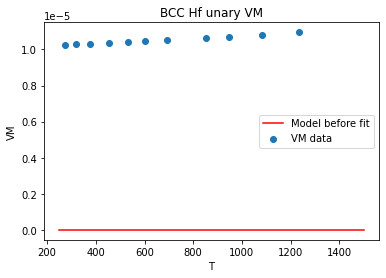

In [6]:

mod = Model(dbf, ["HF"], "BCC_A2")

pT = np.linspace(250, 1500, 1001)
func_HF_VM_nofit = lambdify([v.T], [mod_nofit.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])
func_HF_VM = lambdify([v.T], [mod.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])

# raw V0s from DFT
data_T = np.asarray(datasets[1]["conditions"]["T"])
data_VM = np.asarray(datasets[1]["values"]).squeeze()


plt.title("BCC Hf unary VM")
# plt.plot(pT, func_HF_VM(pT), label="Model after fit")
plt.plot(pT, func_HF_VM_nofit(pT), label="Model before fit", c='r')
plt.scatter(data_T, data_VM, label='VM data')
plt.legend()
plt.xlabel("T")
plt.ylabel("VM")
# plt.xlim(0, 1)

Text(0, 0.5, 'VM')

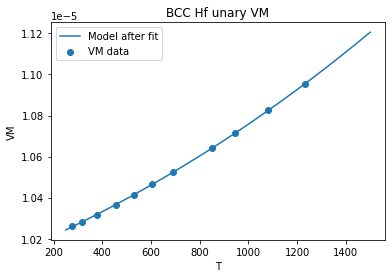

In [7]:
pT = np.linspace(250, 1500, 1001)
func_HF_VM_nofit = lambdify([v.T], [mod_nofit.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])
func_HF_VM = lambdify([v.T], [mod.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])

# raw V0s from DFT
data_T = np.asarray(datasets[1]["conditions"]["T"])
data_VM = np.asarray(datasets[1]["values"]).squeeze()


plt.title("BCC Hf unary VM")
plt.plot(pT, func_HF_VM(pT), label="Model after fit")
# plt.plot(pT, func_HF_VM_nofit(pT), label="Model before fit", c='r')
plt.scatter(data_T, data_VM, label='VM data')
plt.legend()
plt.xlabel("T")
plt.ylabel("VM")
# plt.xlim(0, 1)

## Binary fitting

### Basic 1 point data

In [8]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    # dummy dataset for 50/50 composition, eventually these should be real ESPEI datasets
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "output": "V0",
        "values": [[[1.00448925e-05]]],  # "fixed" value (absolute value from mix data with calphd reference state) extracted manually from above
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]]], "sublattice_occupancies": [[[0.5, 0.5]]]},
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, ["TA", "W"], "BCC_A2")

print(f"Model components (for verification): {mod.components}")

Model components (for verification): [Species('TA', 'TA1'), Species('W', 'W1')]


In [9]:
fit_model_x(molar_volume_fit_desc, datasets, dbf)  # parameter added automatically

fitting_step <class '__main__.StepV0'>
Adding V0 parameters to BCC_A2 (('TA', 'W'),) -4.00189999999996e-07
fitting_step <class '__main__.StepLogVA'>
exiting with no data


[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

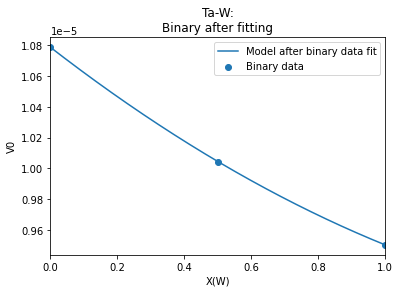

In [10]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

data_1pt_x_W = data_5pt_x_W[[0,2,4]]
data_1pt_V0 = data_5pt_V0_fix[[0,2,4]]

plt.title("Ta-W:\nBinary after fitting")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
plt.scatter(data_1pt_x_W, data_1pt_V0, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

Repeat the above, but now use a real dataset

In [11]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
        "values": [[[1.04002492e-05, 1.00448925e-05, 9.76045653e-06]]],  # fixed values from calculation w/ calphad refstate
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, ["TA", "W"], "BCC_A2")

print(f"Model components (for verification): {mod.components}")

Model components (for verification): [Species('TA', 'TA1'), Species('W', 'W1')]


In [12]:
fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class '__main__.StepV0'>
Adding V0 parameters to BCC_A2 (('TA', 'W'),) -3.70688381176468e-07
fitting_step <class '__main__.StepLogVA'>
exiting with no data


mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

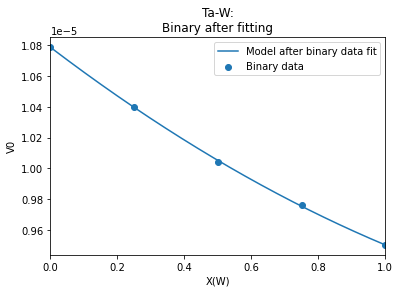

In [13]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Ta-W:\nBinary after fitting")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
plt.scatter(data_5pt_x_W, data_5pt_V0_fix, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

## Mixing

In [14]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0_MIX",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
        "values": [[[-6.58257874e-08, -1.00257453e-07, -6.37684692e-08]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")

fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class '__main__.StepV0'>
Adding V0 parameters to BCC_A2 (('TA', 'W'),) -3.71676509082353e-07
fitting_step <class '__main__.StepLogVA'>
exiting with no data


mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

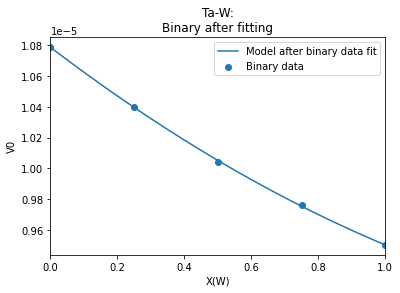

In [15]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Ta-W:\nBinary after fitting")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
plt.scatter(data_5pt_x_W, data_5pt_V0_fix, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

# Ternary

start with binary fitting

In [16]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0_MIX",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
        "values": [[[-6.58257874e-08, -1.00257453e-07, -6.37684692e-08]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")

fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class '__main__.StepV0'>
Adding V0 parameters to BCC_A2 (('TA', 'W'),) -3.71676509082353e-07
fitting_step <class '__main__.StepLogVA'>
exiting with no data


mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

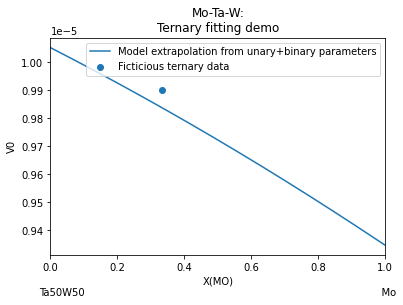

In [17]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "MO", "W"], "BCC_A2")

x_MO = np.linspace(0, 1, 1001)
x_TA = (1 - x_MO) / 2
x_W = (1 - x_MO) / 2
x_MO_TA_W = np.empty((x_MO.shape[-1], 3))
x_MO_TA_W[:, 0] = x_MO
x_MO_TA_W[:, 1] = x_TA
x_MO_TA_W[:, 2] = x_W
func_V0_MO_TA_W = lambdify([v.Y("BCC_A2", 0, "MO"), v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Mo-Ta-W:\nTernary fitting demo")
plt.plot(x_MO, func_V0_MO_TA_W(x_MO_TA_W), label="Model extrapolation from unary+binary parameters")
plt.scatter(0.333, 0.99e-5, label='Ficticious ternary data')
plt.legend(loc="upper right")
plt.xlabel(f"X(MO)\nTa50W50{'':>95}Mo")
plt.ylabel("V0")
plt.xlim(0, 1)

## Fit

In [18]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    {
        "components": ["MO", "TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["MO", "TA", "W"]]], "sublattice_occupancies": [[[0.333333, 0.333333, 0.333333]]]},
        "values": [[[0.99e-5]]],  # ficitious value
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
mod = Model(dbf, ["MO", "TA", "W"], "BCC_A2")

print(f"Model components (for verification): {mod.components}")

Model components (for verification): [Species('MO', 'MO1'), Species('TA', 'TA1'), Species('W', 'W1')]


In [19]:
fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class '__main__.StepV0'>
Adding V0 parameters to BCC_A2 (('MO', 'TA', 'W'),) 1.69138740387224e-06
fitting_step <class '__main__.StepLogVA'>
exiting with no data


mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

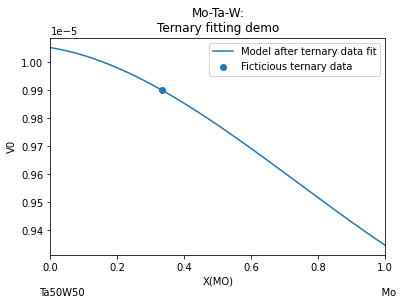

In [20]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "MO", "W"], "BCC_A2")

x_MO = np.linspace(0, 1, 1001)
x_TA = (1 - x_MO) / 2
x_W = (1 - x_MO) / 2
x_MO_TA_W = np.empty((x_MO.shape[-1], 3))
x_MO_TA_W[:, 0] = x_MO
x_MO_TA_W[:, 1] = x_TA
x_MO_TA_W[:, 2] = x_W
func_V0_MO_TA_W = lambdify([v.Y("BCC_A2", 0, "MO"), v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Mo-Ta-W:\nTernary fitting demo")
plt.plot(x_MO, func_V0_MO_TA_W(x_MO_TA_W), label="Model after ternary data fit")
plt.scatter(0.333, 0.99e-5, label='Ficticious ternary data')
plt.legend(loc="upper right")
plt.xlabel(f"X(MO)\nTa50W50{'':>95}Mo")
plt.ylabel("V0")
plt.xlim(0, 1)